# Blackjack Simulation and Bayesian Analysis
# This notebook simulates Blackjack games using a simple predefined policy.

Student: Aly Ahmed Lotfy
ID: 221000412
Reference: https://www.pymc.io/welcome.html

In [ ]:
pip install pymc 

  Using cached pymc-5.18.2-py3-none-any.whl.metadata (15 kB)
  Using cached arviz-0.20.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached cloudpickle-3.1.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached xarray-2024.11.0-py3-none-any.whl.metadata (11 kB)
  Using cached h5netcdf-1.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached xarray_einstats-0.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached etuples-0.3.9.tar.gz (30 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached logical-unification-0.4.6.tar.gz (31 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached miniKanren-1.0.3.tar.gz (41 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cons-

In [2]:
pip install arviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importing necessary libraries:
# pymc: For Bayesian modeling
# gym: For simulating the Blackjack environment
# scipy.stats: For probability calculations (e.g., Bernoulli)
# arviz: For visualizing Bayesian results
import pymc as pm
import numpy as np
import gym
from scipy.stats import bernoulli
import arviz as az

In [ ]:
# The environment allows simulation of Blackjack games.
env = gym.make("Blackjack-v1", render_mode=None)

In [ ]:
# If the player's hand total is below 17, they "hit" (draw another card).
# If the hand total is 17 or above, they "stand" (stop drawing).
def policy(state):
    if isinstance(state, int):
        return 0 if state < 17 else 1
    elif isinstance(state, tuple):
        return 0 if state[0] < 17 else 1
    elif isinstance(state, dict):
        return 0 if state.get('player_sum', 0) < 17 else 1
    else:
        raise ValueError(f"Unexpected state format: {state}")

def simulate_blackjack(num_episodes):
    total_rewards = []

    for _ in range(num_episodes):
        result = env.reset()
        if isinstance(result, tuple):
            state = result[0]  
        else:
            state = result  

        done = False
        total_reward = 0

        while not done:
            action = policy(state) 
            result = env.step(action)

            if isinstance(result, tuple) and len(result) == 5:  
                state, reward, done, truncated, info = result
            elif isinstance(result, tuple):  
                state, reward, done, info = result
            else:
                raise ValueError(f"Unexpected result format from step: {result}")

            total_reward += reward

        total_rewards.append(total_reward)

    return total_rewards

c:\Users\ADMIN\anaconda3\envs\DeepLearning\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [reward_prob]


c:\Users\ADMIN\anaconda3\envs\DeepLearning\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
reward_prob  0.212  0.013   0.187    0.235        0.0      0.0    1820.0   

             ess_tail  r_hat  
reward_prob    2646.0    1.0  


array([[<Axes: title={'center': 'reward_prob'}>,
        <Axes: title={'center': 'reward_prob'}>]], dtype=object)

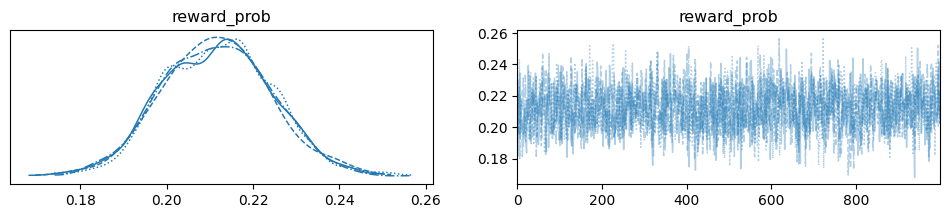

In [ ]:
# reward_prob: Prior belief about the probability of winning.
# likelihood: Observed binary outcomes (win/loss) for each game.
# trace: Posterior samples for the win probability.
with pm.Model() as model:
    reward_prob = pm.Beta("reward_prob", alpha=1, beta=1)

    num_episodes = 1000
    rewards = simulate_blackjack(num_episodes)

    binary_rewards = [1 if r > 0 else 0 for r in rewards]

    likelihood = pm.Bernoulli("likelihood", p=reward_prob, observed=binary_rewards)

    trace = pm.sample(1000, return_inferencedata=True)


# Print a summary of the posterior distribution for reward_prob. this includes the mean, standard deviation, and credible intervals
print(az.summary(trace))
az.plot_trace(trace)
